## Figure S20

In [1]:
import numpy as np, xarray as xr, matplotlib.pylab as plt, pandas as pd, seaborn as sns
import pickle, random, re, io, regionmask, dask, timeit, os, shutil, datetime
from scipy.signal import welch; from eofs.xarray import Eof; import matplotlib as mpl
from scipy.stats import genextreme 

from statsmodels.tsa.api import VAR; from contextlib import redirect_stdout
from distributed import Client; from scipy import stats
import cartopy.crs as ccrs, cartopy.feature as cfeature
import matplotlib.gridspec as gridspec; import cartopy.feature as cfeature
from matplotlib.colors import Normalize; import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from InVERT_functions import (calc_weights, concat_with_monthids, calc_EOFs, areaweighted_mean, 
autocorr, unstack_time, stack_time, createRandomSortedList, compare_T_pdfs, calc_psd_stats, 
plot_GMST_psd_spread, calc_emean_autocorrs, calc_ensemble_std_autocorrs, calc_efold_time, 
calc_eft_stats, compare_autocorrs_emean, plot_GMST_comparisons, save_region_means,
plot_regional_psd_spread, plot_regional_T_pdfs, plot_regional_emean_autocorrs, 
plot_regional_comparison, find_var_name, compare_MSE_to_emean_PSD, welch_psd, get_ensemble_variance, 
calc_emean_gridcell_MSE, plot_regional_variance_stats, plot_regional_eft_stats,
gridcell_map_plot, plot_gridcell_diff, plot_regional_diff_map, calc_gridcell_psd, plot_MSE_by_region,
calc_efold_time_dataset, plot_var_coeffs, convert_lon, emulate_pcs, plot_local_monthly_T_stds)

In [2]:
# Figure formatting
mpl.rcParams['font.family'] = 'sans-serif' 
tickfontsize = 14; axislabelfontsize=16
titlefontsize=18; legendfontsize=14
color1 = 'goldenrod'; color2='teal'

In [3]:
hpath = '/home/msaenger/LENS2_Historical/TREFHT/' # Directory where LENS2 Historical training data is saved
spath = '/home/msaenger/LENS2_SSP370/TREFHT/' # Directory where LENS2 SSP370 training data is saved

## Load monthly temperature anomalies from LENS2 Historical full ensemble
anoms_stacked_HIST = xr.open_dataset(hpath + 'LENS2_TREFHT_anomalies_regridded_concatted.nc')
anoms_HIST = xr.open_dataset(hpath + 'LENS2_TREFHT_anomalies_regridded.nc')

## Load monthly temperature anomalies from LENS2 SSP370 full ensemble
anoms_stacked_SSP = xr.open_dataset(spath + 'LENS2_TREFHT_anomalies_regridded_concatted.nc')
anoms_SSP = xr.open_dataset(spath + 'LENS2_TREFHT_anomalies_regridded.nc')

In [4]:
## Historical time chunks (1850-1899, 1900-1949, 1950-1999)

t1 = anoms_HIST.sel(time=slice('1850', '1899'))
t2 = anoms_HIST.sel(time=slice('1900', '1949'))
t3 = anoms_HIST.sel(time=slice('1950', '1999'))

In [5]:
## Historical + SSP370 time chunk (20-0-2050)
t4_1 = anoms_HIST.sel(time=slice('2000', '2014'))
t4_2 = anoms_SSP.sel(time=slice('2015', '2049'))

t4 = xr.concat([t4_1, t4_2], dim='time')
t4

<xarray.Dataset> Size: 2GB
Dimensions:   (ensemble: 50, time: 600, lat: 96, lon: 192)
Coordinates:
  * time      (time) object 5kB 2000-01-16 00:00:00 ... 2049-12-16 00:00:00
  * lon       (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat       (lat) float64 768B -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * ensemble  (ensemble) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    anoms     (ensemble, time, lat, lon) float32 2GB -1.923 -1.91 ... 1.419
    gmean     (ensemble, time) float64 240kB -0.06734 -0.1027 ... 0.2107 0.4197

In [6]:
## SSP370 time chunk (2050-2100)

t5 = anoms_SSP.sel(time=slice('2050', '2099'))
t5

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 600, lon: 192, lat: 96, ensemble: 50)
Coordinates:
  * time      (time) object 5kB 2050-01-16 00:00:00 ... 2099-12-16 00:00:00
  * lon       (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat       (lat) float64 768B -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * ensemble  (ensemble) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    anoms     (ensemble, time, lat, lon) float32 2GB ...
    gmean     (ensemble, time) float64 240kB ...

## Train InVERT on 50-year 'chunks' from LENS2 (1850-2100)

In [7]:
n_samples = 25   # number of InVERT ensemble members to generate
n_steps = 12 * 50   # number of time steps (months) to generate per InVERT ensemble member 
optimal_lag = 12 # VAR model lag (months)

nmodes = 100     # number of EOF modes to include
M = 120          # Number of initial time steps (months) to truncate for spin-up (aka 'burn-in' period)

In [8]:
LENS_esize = 50  # Size of LENS ensemble (number of members)

In [9]:
# ## Randomly select a subset of ensemble members train on (from each 50-year chunk)

n_training_members = 25 # Number of training ensemble members to use

In [10]:
savepath = '/home/msaenger/InVERT/output/' # Directory where InVERT output and training EOF data is saved

training_anoms = xr.open_dataset(savepath + 'LENS2_Tanoms_25_training_members.nc')
training_members = training_anoms.ensemble.values

testing_anoms = xr.open_dataset(savepath + 'LENS2_Tanoms_25_testing_members.nc')
testing_members = testing_anoms.ensemble.values

In [11]:
print(training_members)

[ 0  1  3  6  7  8 11 13 15 17 18 20 21 23 24 26 28 29 37 38 39 40 43 46
 48]


In [12]:
print(testing_members)

[12 30 36 31 19 34 35 32 42 25 44 14 47 49  9 33 10  5 16 41  4 27 22  2
 45]


In [13]:
training_anoms_t1 = t1.sel(ensemble = [ens for ens in training_members])
training_anoms_t2 = t2.sel(ensemble = [ens for ens in training_members])
training_anoms_t3 = t3.sel(ensemble = [ens for ens in training_members])
training_anoms_t4 = t4.sel(ensemble = [ens for ens in training_members])
training_anoms_t5 = t5.sel(ensemble = [ens for ens in training_members])

In [14]:
training_anoms_t4

<xarray.Dataset> Size: 1GB
Dimensions:   (ensemble: 25, time: 600, lat: 96, lon: 192)
Coordinates:
  * time      (time) object 5kB 2000-01-16 00:00:00 ... 2049-12-16 00:00:00
  * lon       (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat       (lat) float64 768B -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * ensemble  (ensemble) int64 200B 0 1 3 6 7 8 11 13 ... 37 38 39 40 43 46 48
Data variables:
    anoms     (ensemble, time, lat, lon) float32 1GB -1.923 -1.91 ... -2.839
    gmean     (ensemble, time) float64 120kB -0.06734 -0.1027 ... 0.06316

In [15]:
# ## Concatenate training ensemble members over time dimension and save

training_anoms_t1_concatted = concat_with_monthids(training_anoms_t1.anoms)
training_anoms_t2_concatted = concat_with_monthids(training_anoms_t2.anoms)
training_anoms_t3_concatted = concat_with_monthids(training_anoms_t3.anoms)
training_anoms_t4_concatted = concat_with_monthids(training_anoms_t4.anoms)
training_anoms_t5_concatted = concat_with_monthids(training_anoms_t5.anoms)

# ## Save month IDs from original T anomaly time series
month_da = xr.DataArray(training_anoms_t1_concatted.month.values,
                        coords={'time': training_anoms_t1_concatted.time.values, 
                                'month': ('time', training_anoms_t1_concatted.month.values)},
                        dims=['time'])

training_anoms_t1_concatted['month'] = month_da
training_anoms_t2_concatted['month'] = month_da
training_anoms_t3_concatted['month'] = month_da
training_anoms_t4_concatted['month'] = month_da
training_anoms_t5_concatted['month'] = month_da

training_anoms_t1_concatted['gmean'] = areaweighted_mean(training_anoms_t1_concatted.anoms)
training_anoms_t2_concatted['gmean'] = areaweighted_mean(training_anoms_t2_concatted.anoms)
training_anoms_t3_concatted['gmean'] = areaweighted_mean(training_anoms_t3_concatted.anoms)
training_anoms_t4_concatted['gmean'] = areaweighted_mean(training_anoms_t4_concatted.anoms)
training_anoms_t5_concatted['gmean'] = areaweighted_mean(training_anoms_t5_concatted.anoms)

In [16]:
## Save non-training ensemble members for diagnostics (testing)

testing_anoms_t1 = t1.sel(ensemble = testing_members)
testing_anoms_t2 = t2.sel(ensemble = testing_members)
testing_anoms_t3 = t3.sel(ensemble = testing_members)
testing_anoms_t4 = t4.sel(ensemble = testing_members)
testing_anoms_t5 = t5.sel(ensemble = testing_members)

In [17]:
## Concatenate non-training ensemble members over time dimension and save 

testing_anoms_t1_concatted = concat_with_monthids(testing_anoms_t1.anoms)
testing_anoms_t2_concatted = concat_with_monthids(testing_anoms_t2.anoms)
testing_anoms_t3_concatted = concat_with_monthids(testing_anoms_t3.anoms)
testing_anoms_t4_concatted = concat_with_monthids(testing_anoms_t4.anoms)
testing_anoms_t5_concatted = concat_with_monthids(testing_anoms_t5.anoms)

testing_anoms_t1_concatted['month'] = month_da
testing_anoms_t2_concatted['month'] = month_da
testing_anoms_t3_concatted['month'] = month_da
testing_anoms_t4_concatted['month'] = month_da
testing_anoms_t5_concatted['month'] = month_da

testing_anoms_t1_concatted['gmean'] = areaweighted_mean(testing_anoms_t1_concatted.anoms)
testing_anoms_t2_concatted['gmean'] = areaweighted_mean(testing_anoms_t2_concatted.anoms)
testing_anoms_t3_concatted['gmean'] = areaweighted_mean(testing_anoms_t3_concatted.anoms)
testing_anoms_t4_concatted['gmean'] = areaweighted_mean(testing_anoms_t4_concatted.anoms)
testing_anoms_t5_concatted['gmean'] = areaweighted_mean(testing_anoms_t5_concatted.anoms)

In [18]:
### Calculate month-specific EOFs from training ensemble members

savepath = '/home/msaenger/InVERT/output/Figure_S20/'


In [19]:
for (training_anoms, name) in [(training_anoms_t1_concatted, '1850-1899'),
                               (training_anoms_t2_concatted, '1900-1949'),
                               (training_anoms_t3_concatted, '1950-1999'),
                               (training_anoms_t4_concatted, '2000-2049'),
                               (training_anoms_t5_concatted, '2050-2099')]:
    
    print('\n', name, '\n')
    
    for month in range(1,13):
        month_EOFs = calc_EOFs(training_anoms.groupby('month')[month].anoms, path=savepath,
                          filename = 'LENS2_'+ name +'_25_training_monthly_Tanom_EOFs_month='+str(month))
        print('month ' + str(month) + ' EOFs saved')


 1850-1899 

calculating EOFs
done
month 1 EOFs saved
calculating EOFs
done
month 2 EOFs saved
calculating EOFs
done
month 3 EOFs saved
calculating EOFs
done
month 4 EOFs saved
calculating EOFs
done
month 5 EOFs saved
calculating EOFs
done
month 6 EOFs saved
calculating EOFs
done
month 7 EOFs saved
calculating EOFs
done
month 8 EOFs saved
calculating EOFs
done
month 9 EOFs saved
calculating EOFs
done
month 10 EOFs saved
calculating EOFs
done
month 11 EOFs saved
calculating EOFs
done
month 12 EOFs saved

 1900-1949 

calculating EOFs
done
month 1 EOFs saved
calculating EOFs
done
month 2 EOFs saved
calculating EOFs
done
month 3 EOFs saved
calculating EOFs
done
month 4 EOFs saved
calculating EOFs
done
month 5 EOFs saved
calculating EOFs
done
month 6 EOFs saved
calculating EOFs
done
month 7 EOFs saved
calculating EOFs
done
month 8 EOFs saved
calculating EOFs
done
month 9 EOFs saved
calculating EOFs
done
month 10 EOFs saved
calculating EOFs
done
month 11 EOFs saved
calculating EOFs
done
mo

In [20]:
## Run emulator on each set of EOFs and save output

In [21]:
# ## Load EOF solvers by month from training ensemble members

for name in ['1850-1899', '1900-1949', '1950-1999', '2000-2049', '2050-2099']:
    
    print(name)
    
    solvers_bymonth = {}
    for month in range(1,13):
        solvers_bymonth[month] = calc_EOFs(0, path=savepath, 
                                           filename = 'LENS2_'+ name +\
                                           '_25_training_monthly_Tanom_EOFs_month='+str(month))
        
    ## Extract and save PCs, EOFs, and variance fractions from the EOF solver object
    eofs_dict = {}
    for month in range(1, 13):
        eofs_dict[month] = {}
        eofs_dict[month]['eofs'] = solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
        eofs_dict[month]['pcs'] = solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
        eofs_dict[month]['varfracs'] = solvers_bymonth[month].varianceFraction().sel(mode=slice(0, nmodes-1))

    ## Extract cos(lat) weights for later use
    weights = solvers_bymonth[1].getWeights()
    weights = xr.DataArray(weights, coords=[eofs_dict[1]['eofs']['lat'], 
                                            eofs_dict[1]['eofs']['lon']], 
                           dims=['lat', 'lon'])

    ### Compile DataArrays of PCs from the EOF solvers for each month
    pcs_unstacked = {}
    for month in range(1, 13):
        pcs_unstacked[month] = unstack_time(eofs_dict[month]['pcs'].drop('month'), 
                                            esize = n_training_members) 
    training_pcs_bymonth_unstacked = xr.Dataset(pcs_unstacked)
    training_pcs_bymonth = stack_time(training_pcs_bymonth_unstacked)

    # ## Extract each month's PC data array and adjust the 'time' values 
    month_pc_da_list = []
    for month in range(1, 13):
        training_pcs_da_month = training_pcs_bymonth[month].drop('ensemble')
        training_pcs_da_month['time'] = training_pcs_da_month.time * 12 + month - 1
        training_pcs_da_month = training_pcs_da_month.to_dataset(name='pcs')
        month_pc_da_list.append(training_pcs_da_month)

    training_pcs = xr.merge(month_pc_da_list).sortby('time')
    training_pcs['month'] = month_da.sel(time=slice(0,len(training_pcs['time'])))
    training_pcs = training_pcs.assign_coords({'month': training_pcs.month})
    
    training_pcs.to_netcdf(savepath + 'training_pcs_'+name+'.nc')

    ### Train 12 monthly VAR models 
    monthly_var_models = {}
    for target_month in range(1, 13): 
        input_features = []; output_targets = []
        for i in range(optimal_lag, len(training_pcs.time)):
            if training_pcs.month.values[i] == target_month:
                features = training_pcs.pcs.values[i - optimal_lag : i, :].flatten()
                input_features.append(features)
                targets = training_pcs.pcs.values[i, :]
                output_targets.append(targets)
        input_features = np.array(input_features); output_targets = np.array(output_targets)
        if len(input_features) > 0:
            X = np.hstack([np.ones((input_features.shape[0],1)), input_features])
            y = output_targets
            coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
            predicted_targets = X @ coefficients
            residuals = y - predicted_targets
            intercept = coefficients[0, :]
            lagged_coeffs = coefficients[1:, :]
            monthly_var_models[target_month] = {
                'intercept': intercept,
                'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
                'residuals': residuals} 

    ## Emulate PCs and save
    InVERT_pcs = emulate_pcs(training_pcs, monthly_var_models, n_training_members,
                             optimal_lag, n_samples, n_steps, nmodes, M, savepath)

    ## Compute PCs * EOFs for each mode and divide by weights for every month. Save in dict.
    print('Multiplying PCs * EOFs and dividing by weights')
    products_by_month = {}
    for month in range(1, 13):
        print(month)
        products_by_month[month] = InVERT_pcs.groupby('month')[month] * eofs_dict[month]['eofs'] / weights

    ## Sum T anomalies over modes then merge
    print('Summing over modes')
    products_by_month_summed = {}
    for month in range(1, 13):
        print(month)
        products_by_month_summed[month] =  products_by_month[month].pcs.sum(dim='mode')

    ## Re-stack ensemble members over time dim and save in new dict
    print('Stacking ensemble members over time')
    Tanoms_bymonth = {}
    for month in range(1, 13):
        print(month)
        Tanoms_bymonth[month] = (stack_time(products_by_month_summed[month]))

    ## Extract each month's T anomaly data array and adjust the 'time' values so as to put them 
    ## back together in time order 
    print('Updating time indices')
    Tanom_da_list = []
    for month in range(1, 13):
        Tanoms_month = Tanoms_bymonth[month]
        Tanoms_month['time'] = Tanoms_month.time * 12 + month - 1
        Tanoms_month = Tanoms_month.to_dataset(name='T')
        Tanom_da_list.append(Tanoms_month)

    ## Concatenate over time dimension and then sort by time 
    print('Merging and sorting by time')
    InVERT_stacked = xr.concat(Tanom_da_list, dim='time').sortby('time')
    InVERT_stacked['gmean'] = areaweighted_mean(InVERT_stacked.T)
    
    InVERT_stacked.to_netcdf(savepath + 'InVERT_'+ name + '_stacked.nc')

    ## Separate back into ensemble members
    InVERT_T = unstack_time(InVERT_stacked, esize=n_samples)

    print('Saving InVERT with ', nmodes, ' modes')
    InVERT_T.to_netcdf(savepath + 'InVERT_' + name + '.nc')
    print('saved')

1850-1899
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Multiplying PCs * EOFs and dividing by weights
1
2
3
4
5
6
7
8
9
10
11
12
Summing over modes
1
2
3
4
5
6
7
8
9
10
11
12
Stacking ensemble members over time
1
2
3
4
5
6
7
8
9
10
11
12
Updating time indices
Merging and sorting by time
Saving InVERT with  100  modes
saved
1900-1949
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Multiplying PCs * EOFs and dividing by weights
1
2
3
4
5
6
7
8
9
10
11
12
Summing over modes
1
2
3
4
5
6
7
8
9
10
11
12
Stacking ensemble members over time
1
2
3
4
5
6
7
8
9
10
11
12
Updating time indices
Merging and sorting by time
Saving InVERT with  1

#### Diagnostics

In [22]:
InVERT1_stacked = xr.open_dataset(savepath + 'InVERT_1850-1899_stacked.nc')
InVERT2_stacked = xr.open_dataset(savepath + 'InVERT_1900-1949_stacked.nc')
InVERT3_stacked = xr.open_dataset(savepath + 'InVERT_1950-1999_stacked.nc')
InVERT4_stacked = xr.open_dataset(savepath + 'InVERT_2000-2049_stacked.nc')
InVERT5_stacked = xr.open_dataset(savepath + 'InVERT_2050-2099_stacked.nc')

InVERT1 = xr.open_dataset(savepath + 'InVERT_1850-1899.nc')
InVERT2 = xr.open_dataset(savepath + 'InVERT_1900-1949.nc')
InVERT3 = xr.open_dataset(savepath + 'InVERT_1950-1999.nc')
InVERT4 = xr.open_dataset(savepath + 'InVERT_2000-2049.nc')
InVERT5 = xr.open_dataset(savepath + 'InVERT_2050-2099.nc')

In [23]:
## Convert longitude from 0-360 to -180-180

InVERT1_stacked_converted_lon = convert_lon(InVERT1_stacked, 'lon')
InVERT2_stacked_converted_lon = convert_lon(InVERT2_stacked, 'lon')
InVERT3_stacked_converted_lon = convert_lon(InVERT3_stacked, 'lon')
InVERT4_stacked_converted_lon = convert_lon(InVERT4_stacked, 'lon')
InVERT5_stacked_converted_lon = convert_lon(InVERT5_stacked, 'lon')

InVERT1_converted_lon = convert_lon(InVERT1, 'lon')
InVERT2_converted_lon = convert_lon(InVERT2, 'lon')
InVERT3_converted_lon = convert_lon(InVERT3, 'lon')
InVERT4_converted_lon = convert_lon(InVERT4, 'lon')
InVERT5_converted_lon = convert_lon(InVERT5, 'lon')

In [24]:
lens1_converted_lon = convert_lon(testing_anoms_t1, 'lon')
lens2_converted_lon = convert_lon(testing_anoms_t2, 'lon')
lens3_converted_lon = convert_lon(testing_anoms_t3, 'lon')
lens4_converted_lon = convert_lon(testing_anoms_t4, 'lon')
lens5_converted_lon = convert_lon(testing_anoms_t5, 'lon')

lens1_stacked_converted_lon = convert_lon(testing_anoms_t1_concatted, 'lon')
lens2_stacked_converted_lon = convert_lon(testing_anoms_t2_concatted, 'lon')
lens3_stacked_converted_lon = convert_lon(testing_anoms_t3_concatted, 'lon')
lens4_stacked_converted_lon = convert_lon(testing_anoms_t4_concatted, 'lon')
lens5_stacked_converted_lon = convert_lon(testing_anoms_t5_concatted, 'lon')

In [25]:
lens1_converted_lon['time'] = np.arange(0, 600)
lens1_converted_lon = lens1_converted_lon.assign_coords({'month':month_da})

lens2_converted_lon['time'] = np.arange(0, 600)
lens2_converted_lon = lens2_converted_lon.assign_coords({'month':month_da})

lens3_converted_lon['time'] = np.arange(0, 600)
lens3_converted_lon = lens3_converted_lon.assign_coords({'month':month_da})

lens4_converted_lon['time'] = np.arange(0, 600)
lens4_converted_lon = lens4_converted_lon.assign_coords({'month':month_da})

lens5_converted_lon['time'] = np.arange(0, 600)
lens5_converted_lon = lens5_converted_lon.assign_coords({'month':month_da})

In [26]:
## Calculate standard deviations of T anomalies by month (for ensembles stacked in time)

lens1_monthly_stds = lens1_stacked_converted_lon.anoms.groupby('month').std('time')
lens2_monthly_stds = lens2_stacked_converted_lon.anoms.groupby('month').std('time')
lens3_monthly_stds = lens3_stacked_converted_lon.anoms.groupby('month').std('time')
lens4_monthly_stds = lens4_stacked_converted_lon.anoms.groupby('month').std('time')
lens5_monthly_stds = lens5_stacked_converted_lon.anoms.groupby('month').std('time')

In [27]:
InVERT1_monthly_stds = InVERT1_stacked_converted_lon.T.groupby('month').std('time')
InVERT2_monthly_stds = InVERT2_stacked_converted_lon.T.groupby('month').std('time')
InVERT3_monthly_stds = InVERT3_stacked_converted_lon.T.groupby('month').std('time')
InVERT4_monthly_stds = InVERT4_stacked_converted_lon.T.groupby('month').std('time')
InVERT5_monthly_stds = InVERT5_stacked_converted_lon.T.groupby('month').std('time')

In [28]:
# Calculate ensemble mean and ensemble std of T anomaly standard deviations by month

lens1_emean_monthly_stds = lens1_converted_lon.anoms.groupby('month').std('time').mean('ensemble')
lens2_emean_monthly_stds = lens2_converted_lon.anoms.groupby('month').std('time').mean('ensemble')
lens3_emean_monthly_stds = lens3_converted_lon.anoms.groupby('month').std('time').mean('ensemble')
lens4_emean_monthly_stds = lens4_converted_lon.anoms.groupby('month').std('time').mean('ensemble')
lens5_emean_monthly_stds = lens5_converted_lon.anoms.groupby('month').std('time').mean('ensemble')

In [29]:
lens1_estd_monthly_stds = lens1_converted_lon.anoms.groupby('month').std('time').std('ensemble')
lens2_estd_monthly_stds = lens2_converted_lon.anoms.groupby('month').std('time').std('ensemble')
lens3_estd_monthly_stds = lens3_converted_lon.anoms.groupby('month').std('time').std('ensemble')
lens4_estd_monthly_stds = lens4_converted_lon.anoms.groupby('month').std('time').std('ensemble')
lens5_estd_monthly_stds = lens5_converted_lon.anoms.groupby('month').std('time').std('ensemble')

In [30]:
def plot_local_monthly_T_stds(LENS_emean_monthly_stds, LENS_estd_monthly_stds,
                              InVERT1_monthly_stds, InVERT2_monthly_stds, InVERT3_monthly_stds,
                              InVERT4_monthly_stds, InVERT5_monthly_stds,
                              locations_lat_lon, lens_ref_period, 
                              ylim=3, markersize=9, capsize=4, elinewidth=1.5, 
                              markeredgewidth=1.5,):
    '''
    Add input arg lens_ref_period (str): reference time range from LENS2 simulations
    '''

    n_locations = len(locations_lat_lon)
    if n_locations != 4:
        print("Please provide exactly four locations.")
        return

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), squeeze=False) # 2x2 grid
    axes = axes.flatten()
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']

    for i, (lat, lon, location) in enumerate(locations_lat_lon):
        ax = axes[i] # Get the current subplot axis

        invert1_local = InVERT1_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert2_local = InVERT2_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert3_local = InVERT3_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert4_local = InVERT4_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert5_local = InVERT5_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        
        lens_emean_local = LENS_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        lens_estd_local = LENS_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')

        lat_selected = np.round(invert1_local.lat.values, 2)
        lon_selected = np.round(invert1_local.lon.values, 2)

        print(f"{location}: {invert1_local.lat.values}, {invert1_local.lon.values}")

        if lat_selected >= 0: NS_hemisphere = 'N'
        else: NS_hemisphere = 'S'
        if lon_selected >= 0: EW_hemisphere = 'E'
        else: EW_hemisphere = 'W' 

        ## InVERT
        ax.plot(np.arange(1.1, 13.1), invert1_local, '*', markersize=markersize, 
                label='InVERT 1850-1899', color='purple')  
        ax.plot(np.arange(1.1, 13.1), invert2_local, '*', markersize=markersize, 
                label='InVERT 1900-1949', color='navy')  
        ax.plot(np.arange(1.1, 13.1), invert3_local, '*', markersize=markersize, 
                label='InVERT 1950-1999', color='forestgreen')  
        ax.plot(np.arange(1.1, 13.1), invert4_local, '*', markersize=markersize, 
                label='InVERT 2000-2049', color='goldenrod')  
        ax.plot(np.arange(1.1, 13.1), invert5_local, '*', markersize=markersize, 
                label='InVERT 2050-2099', color='red')  
        
        ## LENS
        ax.plot(np.arange(1, 13), lens_emean_local, 'o', markersize=markersize-2, 
                label='LENS2 ' + lens_ref_period, color='black')#, markerfacecolor='none')  
        
        ax.errorbar(np.arange(1, 13), lens_emean_local, yerr=lens_estd_local,
                    fmt='none', markersize=markersize, capsize=capsize, color='black', 
                    ecolor='black', elinewidth=elinewidth,
                    markeredgewidth=markeredgewidth) 
            
        ax.set_ylim(0,ylim[i]); ax.set_xlim(0.5,12.5)
        ax.set_xlabel('month', fontsize=axislabelfontsize)
        ax.set_xticks([2,4,6,8,10,12])
        ax.set_xticklabels(['2', '4', '6', '8', '10', '12'], fontsize=tickfontsize)
        
        if ylim[i] == 2:
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['0', '1', '2'])
        if ylim[i] == 3:
            ax.set_yticks([0,1,2,3])
            ax.set_yticklabels(['0', '1', '2', '3'])
        if ylim[i] == 1.5:
            ax.set_yticks([0,0.5,1,1.5])
            ax.set_yticklabels(['0', '0.5', '1', '1.5'])
        if ylim[i] == 2.5:
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['0', '1', '2'])
        ax.set_title(location, fontsize=titlefontsize)
        if i == 0: # Add legend only to the top-left subplot
            ax.legend(fontsize=legendfontsize-1)

        ax.set_ylabel('standard deviation [K]', fontsize=axislabelfontsize)
        ax.text(-0.05, 1.1, subplot_labels[i], transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left', zorder=10)
        
    plt.suptitle('Local T anomaly standard deviations by month', fontsize=26)
    plt.tight_layout()

    fig.savefig(savepath + 'Figure_S20_local_monthly_stds_' + lens_ref_period + '.png')
    fig.savefig(savepath + 'Figure_S20_local_monthly_stds_' + lens_ref_period + '.pdf')

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


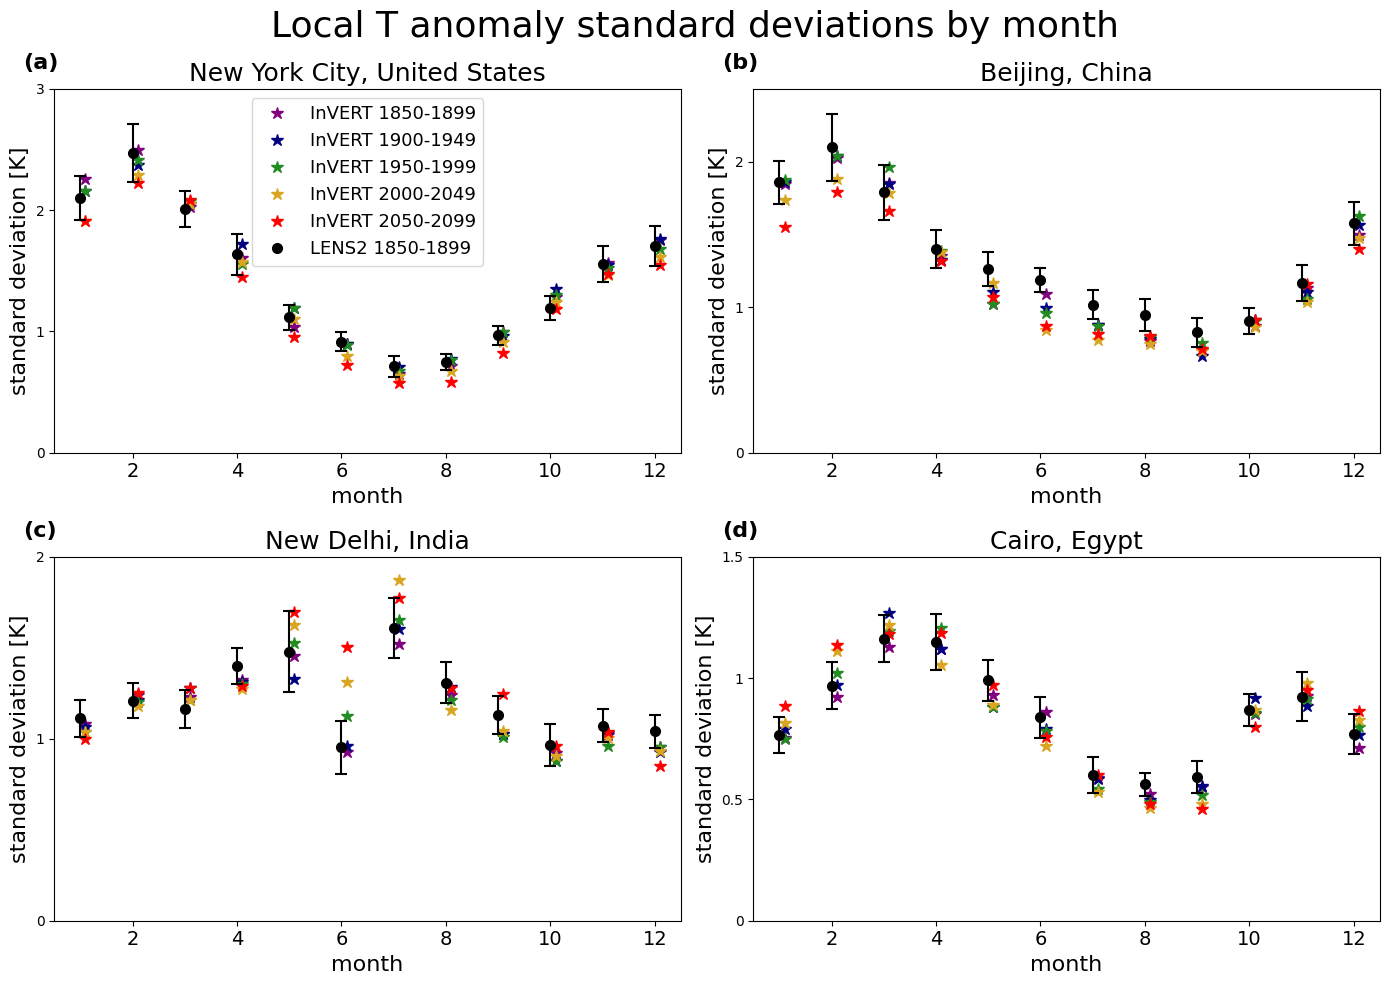

In [31]:
locations_lat_lon = [(40.7, -74, 'New York City, United States'),
                     (39.9, 116.4, 'Beijing, China'),
                     (28.7, 77.2, 'New Delhi, India'),
                     (30.05, 31.23, 'Cairo, Egypt' )]

plot_local_monthly_T_stds(lens1_emean_monthly_stds, lens1_estd_monthly_stds,
                          InVERT1_monthly_stds, InVERT2_monthly_stds, 
                          InVERT3_monthly_stds, InVERT4_monthly_stds, 
                          InVERT5_monthly_stds,
                          locations_lat_lon, lens_ref_period='1850-1899',
                          ylim=[3,2.5,2,1.5]) 

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


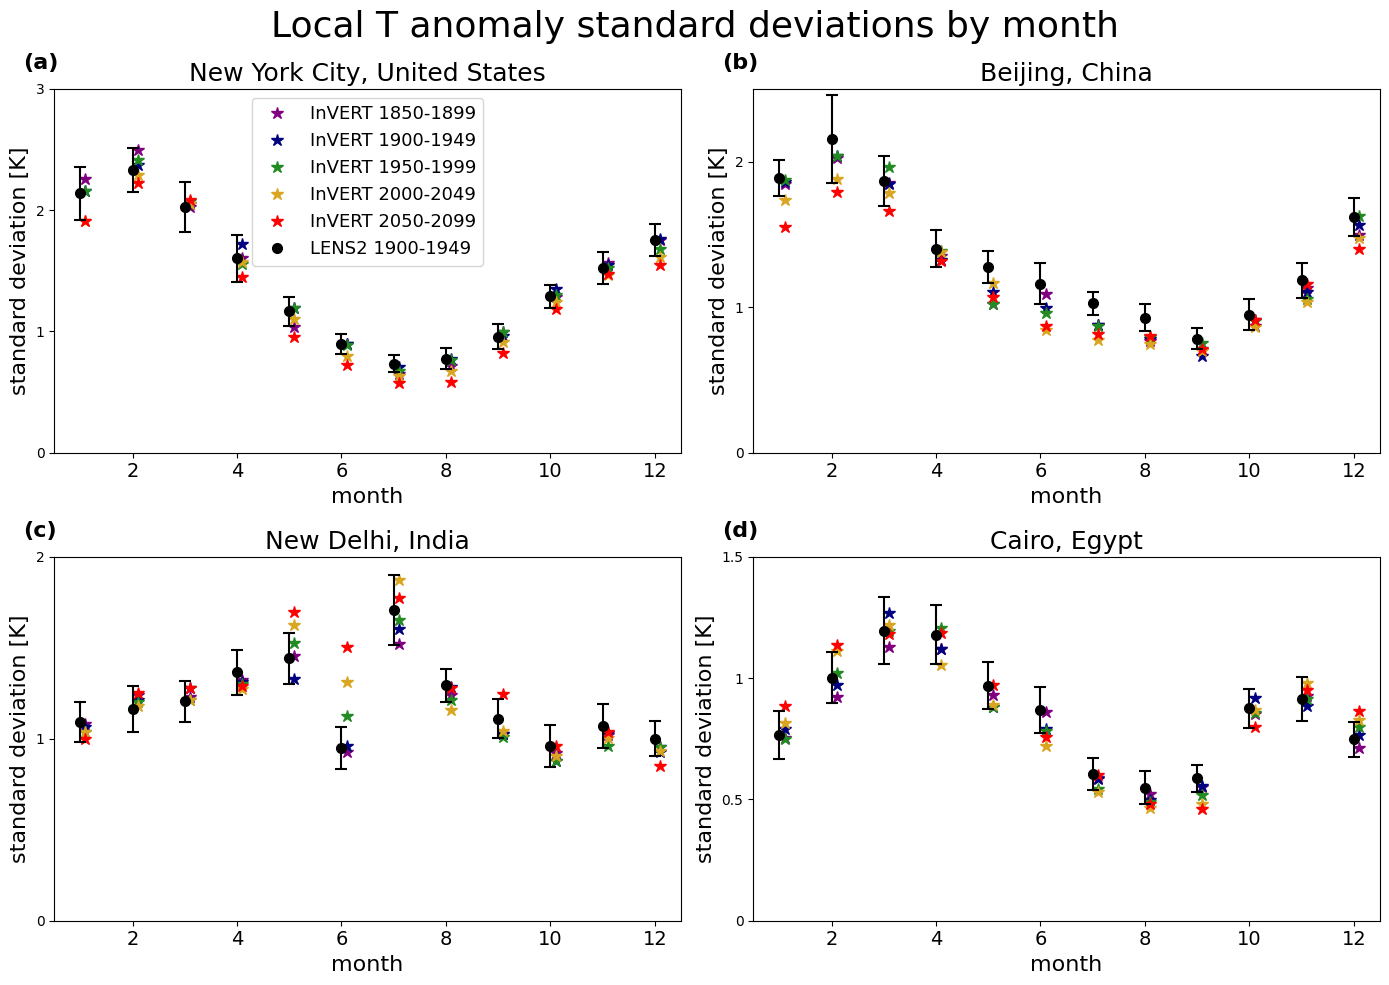

In [32]:
plot_local_monthly_T_stds(lens2_emean_monthly_stds, lens2_estd_monthly_stds,
                          InVERT1_monthly_stds, InVERT2_monthly_stds, 
                          InVERT3_monthly_stds, InVERT4_monthly_stds, 
                          InVERT5_monthly_stds,
                          locations_lat_lon, lens_ref_period='1900-1949',
                          ylim=[3,2.5,2,1.5]) 

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


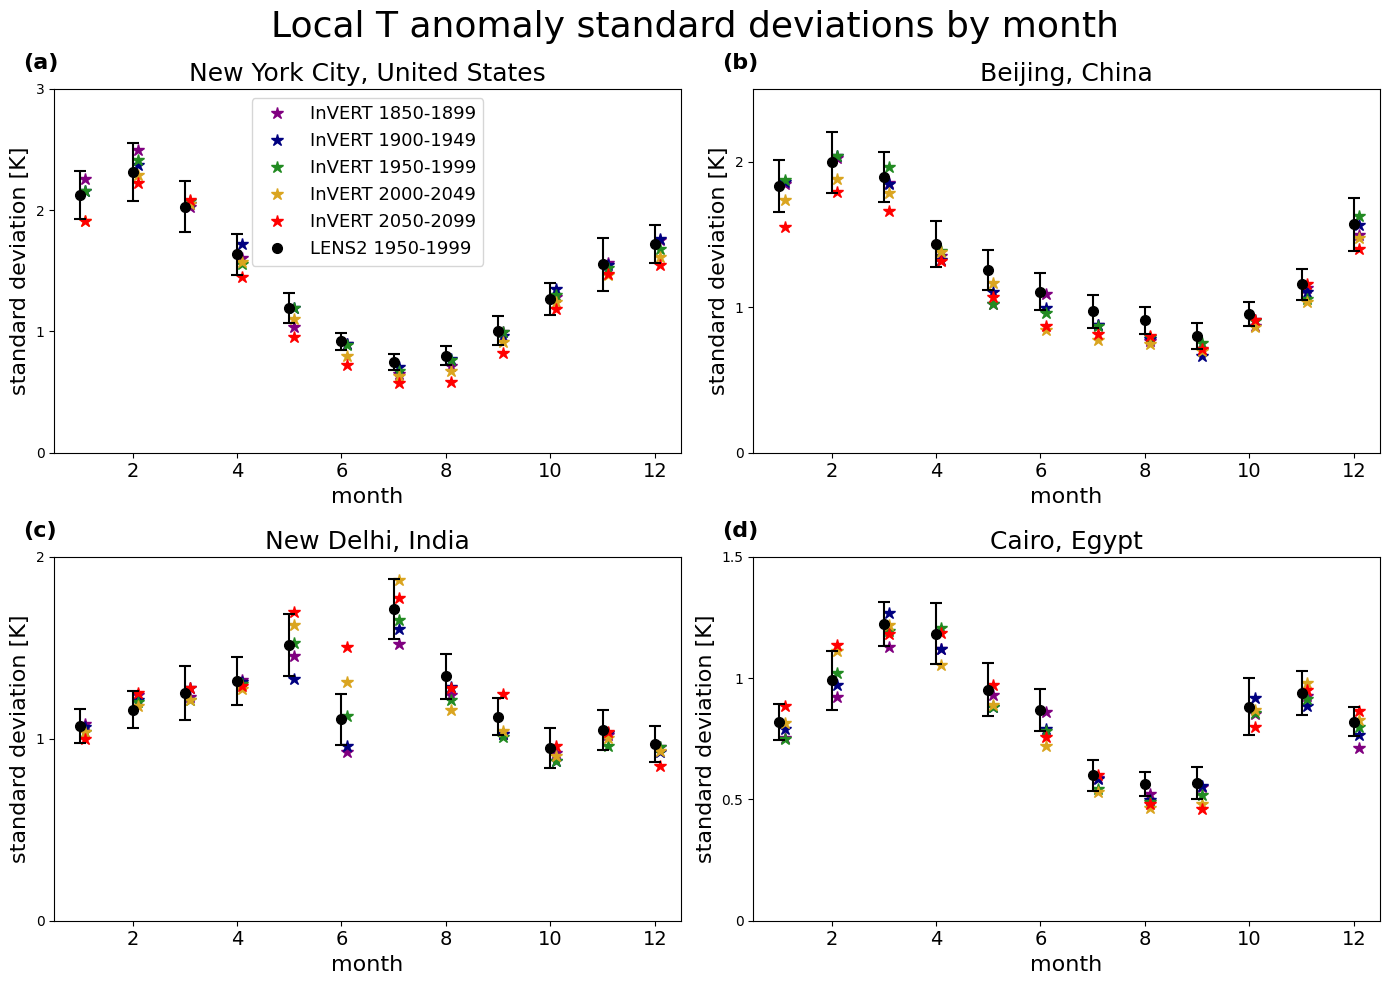

In [33]:
plot_local_monthly_T_stds(lens3_emean_monthly_stds, lens3_estd_monthly_stds,
                          InVERT1_monthly_stds, InVERT2_monthly_stds, 
                          InVERT3_monthly_stds, InVERT4_monthly_stds, 
                          InVERT5_monthly_stds,
                          locations_lat_lon, lens_ref_period='1950-1999',
                          ylim=[3,2.5,2,1.5]) 

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


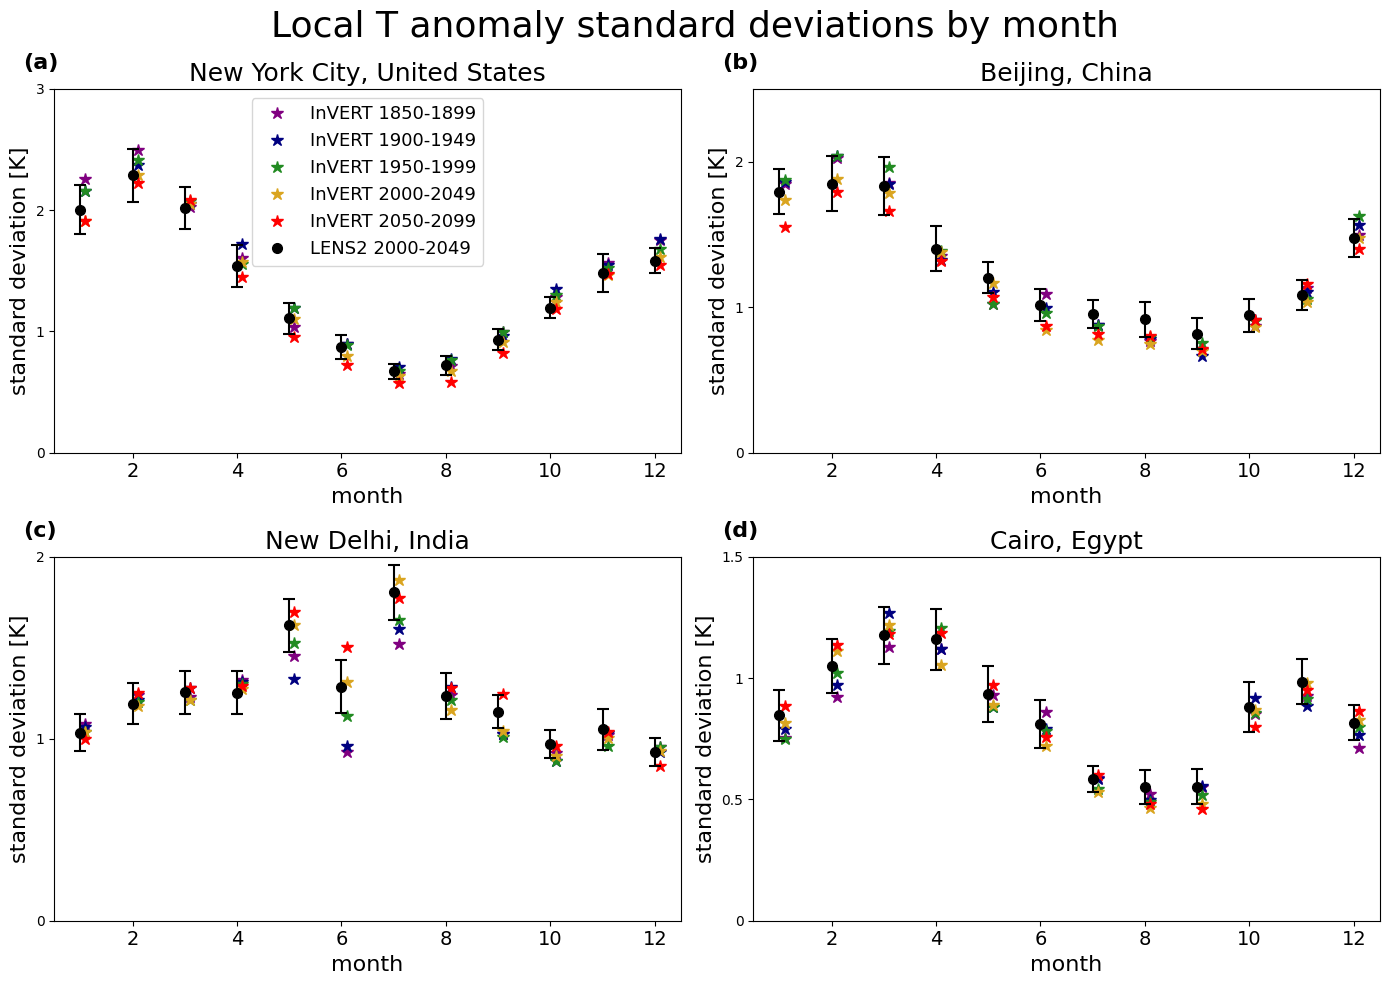

In [34]:
plot_local_monthly_T_stds(lens4_emean_monthly_stds, lens4_estd_monthly_stds,
                          InVERT1_monthly_stds, InVERT2_monthly_stds, 
                          InVERT3_monthly_stds, InVERT4_monthly_stds, 
                          InVERT5_monthly_stds,
                          locations_lat_lon, lens_ref_period='2000-2049',
                          ylim=[3,2.5,2,1.5]) 

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


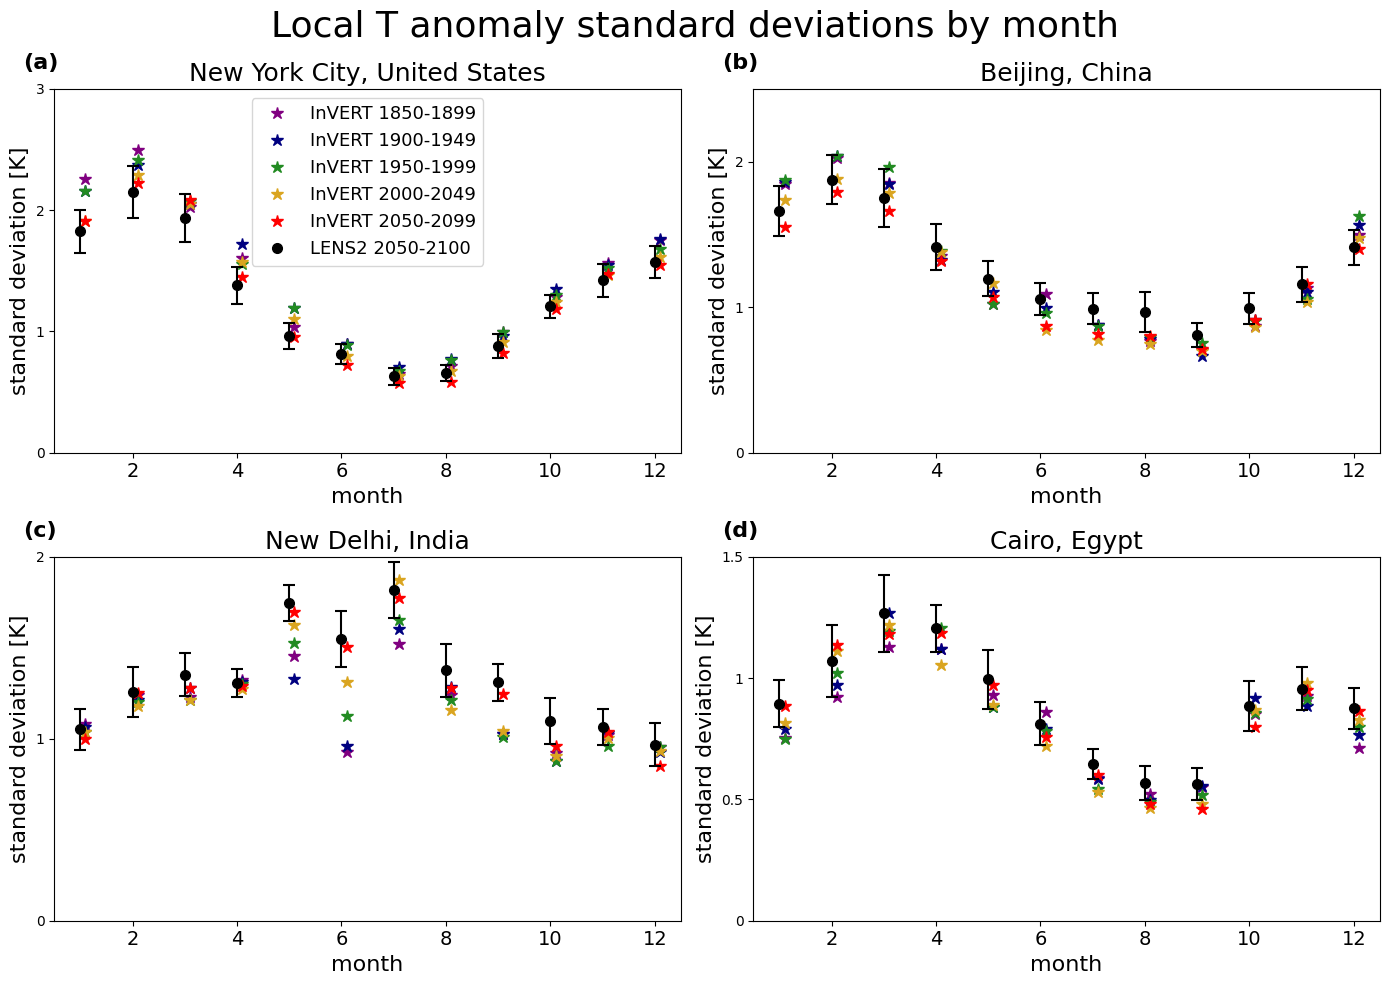

In [35]:
plot_local_monthly_T_stds(lens5_emean_monthly_stds, lens5_estd_monthly_stds,
                          InVERT1_monthly_stds, InVERT2_monthly_stds, 
                          InVERT3_monthly_stds, InVERT4_monthly_stds, 
                          InVERT5_monthly_stds,
                          locations_lat_lon, lens_ref_period='2050-2100',
                          ylim=[3,2.5,2,1.5]) 

In [36]:
# Compute gridcell standard deviations over time dimension

std_invert1 = InVERT1_stacked.T.std('time')
std_invert2 = InVERT2_stacked.T.std('time')
std_invert3 = InVERT3_stacked.T.std('time')
std_invert4 = InVERT4_stacked.T.std('time')
std_invert5 = InVERT5_stacked.T.std('time')

In [37]:
std_lens1 = testing_anoms_t1_concatted.anoms.std('time')
std_lens2 = testing_anoms_t2_concatted.anoms.std('time')
std_lens3 = testing_anoms_t3_concatted.anoms.std('time')
std_lens4 = testing_anoms_t4_concatted.anoms.std('time')
std_lens5 = testing_anoms_t5_concatted.anoms.std('time')

## PDFs of gridcell standard deviation absolute difference [K]

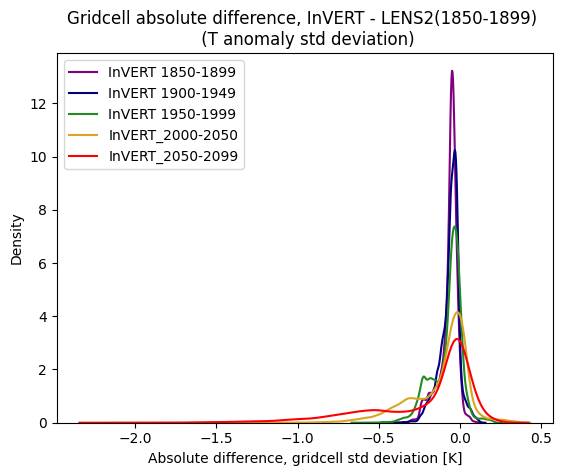

In [38]:
# Test all InVERT scenarios against LENS 1850-1899

lens_ref_period = '1850-1899'

invert1_std_abs_diff = ((std_invert1 - std_lens1).values).flatten()
invert2_std_abs_diff = ((std_invert2 - std_lens1).values).flatten()
invert3_std_abs_diff = ((std_invert3 - std_lens1).values).flatten()
invert4_std_abs_diff = ((std_invert4 - std_lens1).values).flatten()
invert5_std_abs_diff = ((std_invert5 - std_lens1).values).flatten()

sns.kdeplot(invert1_std_abs_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_abs_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_abs_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_abs_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_abs_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.pdf')

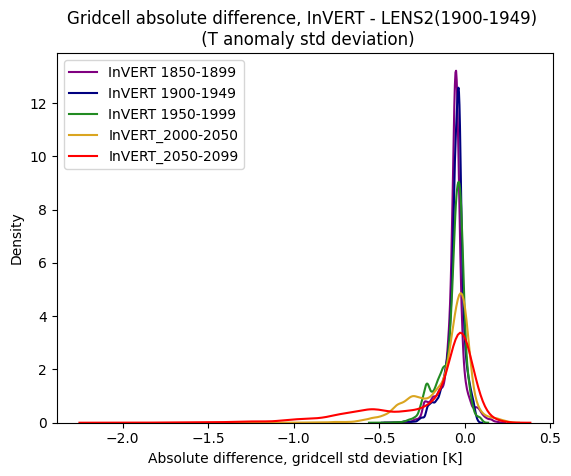

In [39]:
# Test all InVERT scenarios against LENS 1900-1949

lens_ref_period = '1900-1949'

invert1_std_abs_diff = ((std_invert1 - std_lens2).values).flatten()
invert2_std_abs_diff = ((std_invert2 - std_lens2).values).flatten()
invert3_std_abs_diff = ((std_invert3 - std_lens2).values).flatten()
invert4_std_abs_diff = ((std_invert4 - std_lens2).values).flatten()
invert5_std_abs_diff = ((std_invert5 - std_lens2).values).flatten()

sns.kdeplot(invert1_std_abs_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_abs_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_abs_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_abs_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_abs_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.pdf')

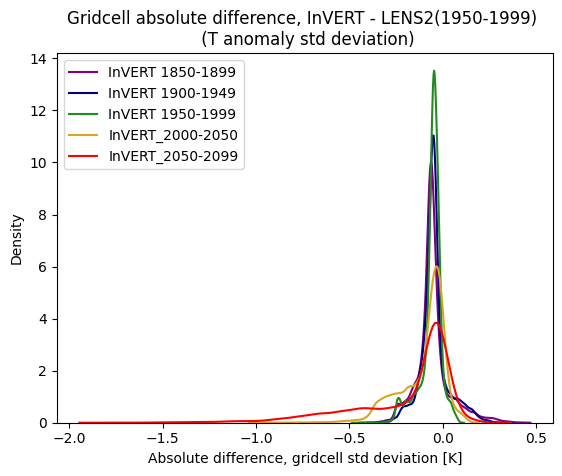

In [40]:
# Test all InVERT scenarios against LENS 1950-1999

lens_ref_period = '1950-1999'

invert1_std_abs_diff = ((std_invert1 - std_lens3).values).flatten()
invert2_std_abs_diff = ((std_invert2 - std_lens3).values).flatten()
invert3_std_abs_diff = ((std_invert3 - std_lens3).values).flatten()
invert4_std_abs_diff = ((std_invert4 - std_lens3).values).flatten()
invert5_std_abs_diff = ((std_invert5 - std_lens3).values).flatten()

sns.kdeplot(invert1_std_abs_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_abs_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_abs_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_abs_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_abs_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.pdf')

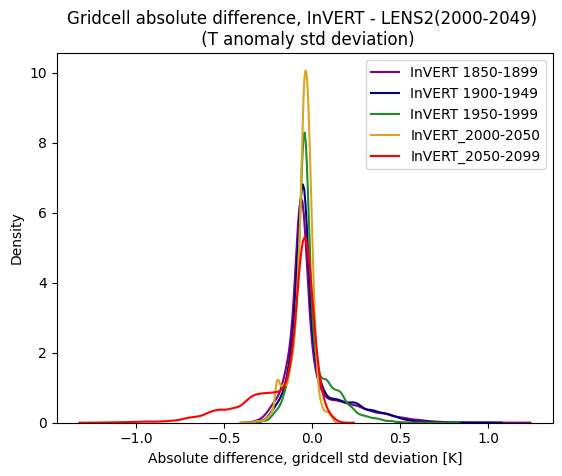

In [41]:
# Test all InVERT scenarios against LENS 2000-2049

lens_ref_period = '2000-2049'

invert1_std_abs_diff = ((std_invert1 - std_lens4).values).flatten()
invert2_std_abs_diff = ((std_invert2 - std_lens4).values).flatten()
invert3_std_abs_diff = ((std_invert3 - std_lens4).values).flatten()
invert4_std_abs_diff = ((std_invert4 - std_lens4).values).flatten()
invert5_std_abs_diff = ((std_invert5 - std_lens4).values).flatten()

sns.kdeplot(invert1_std_abs_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_abs_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_abs_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_abs_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_abs_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.pdf')

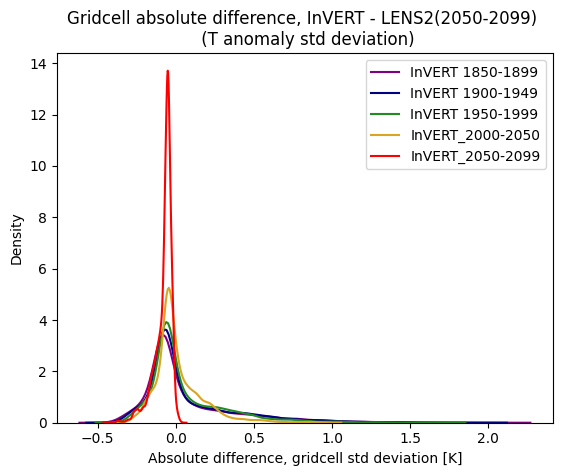

In [42]:
# Test all InVERT scenarios against LENS 2000-2099

lens_ref_period = '2050-2099'

invert1_std_abs_diff = ((std_invert1 - std_lens5).values).flatten()
invert2_std_abs_diff = ((std_invert2 - std_lens5).values).flatten()
invert3_std_abs_diff = ((std_invert3 - std_lens5).values).flatten()
invert4_std_abs_diff = ((std_invert4 - std_lens5).values).flatten()
invert5_std_abs_diff = ((std_invert5 - std_lens5).values).flatten()

sns.kdeplot(invert1_std_abs_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_abs_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_abs_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_abs_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_abs_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_absolute_diff_'+lens_ref_period+'.pdf')

## PDFs of gridcell standard deviation relative difference [%]

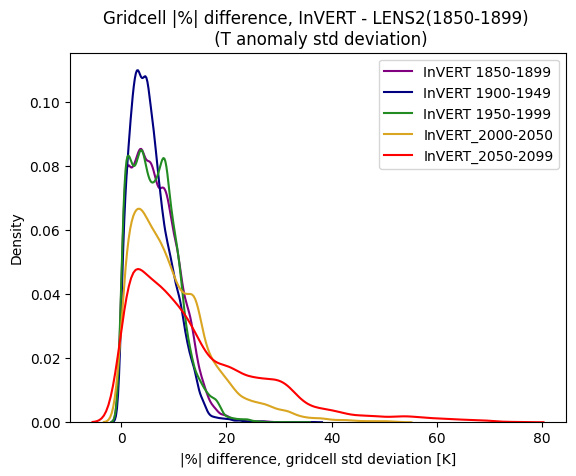

In [43]:
lens_ref_period = '1850-1899'
std_lens = std_lens1

invert1_std_pct_diff = (np.abs(std_invert1 - std_lens)/std_lens*100).values.flatten()
invert2_std_pct_diff = (np.abs(std_invert2 - std_lens)/std_lens*100).values.flatten()
invert3_std_pct_diff = (np.abs(std_invert3 - std_lens)/std_lens*100).values.flatten()
invert4_std_pct_diff = (np.abs(std_invert4 - std_lens)/std_lens*100).values.flatten()
invert5_std_pct_diff = (np.abs(std_invert5 - std_lens)/std_lens*100).values.flatten()

sns.kdeplot(invert1_std_pct_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_pct_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_pct_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_pct_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_pct_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('|%| difference, gridcell std deviation [K]')
plt.title('Gridcell |%| difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.pdf')

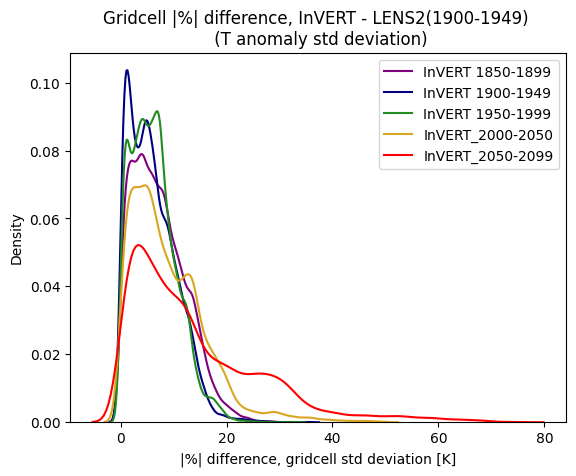

In [44]:
lens_ref_period = '1900-1949'
std_lens = std_lens2

invert1_std_pct_diff = (np.abs(std_invert1 - std_lens)/std_lens*100).values.flatten()
invert2_std_pct_diff = (np.abs(std_invert2 - std_lens)/std_lens*100).values.flatten()
invert3_std_pct_diff = (np.abs(std_invert3 - std_lens)/std_lens*100).values.flatten()
invert4_std_pct_diff = (np.abs(std_invert4 - std_lens)/std_lens*100).values.flatten()
invert5_std_pct_diff = (np.abs(std_invert5 - std_lens)/std_lens*100).values.flatten()

sns.kdeplot(invert1_std_pct_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_pct_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_pct_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_pct_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_pct_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('|%| difference, gridcell std deviation [K]')
plt.title('Gridcell |%| difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.pdf')

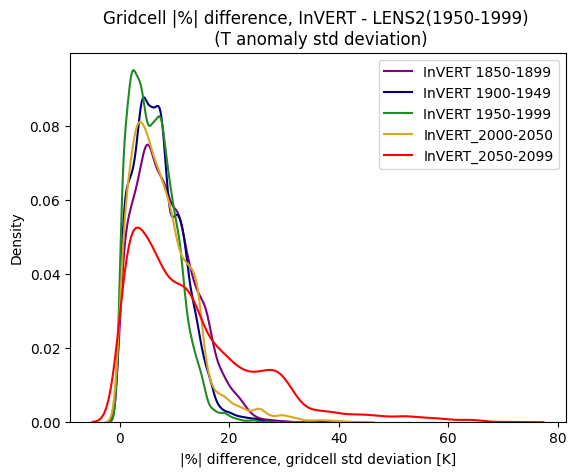

In [45]:
lens_ref_period = '1950-1999'
std_lens = std_lens3

invert1_std_pct_diff = (np.abs(std_invert1 - std_lens)/std_lens*100).values.flatten()
invert2_std_pct_diff = (np.abs(std_invert2 - std_lens)/std_lens*100).values.flatten()
invert3_std_pct_diff = (np.abs(std_invert3 - std_lens)/std_lens*100).values.flatten()
invert4_std_pct_diff = (np.abs(std_invert4 - std_lens)/std_lens*100).values.flatten()
invert5_std_pct_diff = (np.abs(std_invert5 - std_lens)/std_lens*100).values.flatten()

sns.kdeplot(invert1_std_pct_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_pct_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_pct_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_pct_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_pct_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('|%| difference, gridcell std deviation [K]')
plt.title('Gridcell |%| difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.pdf')

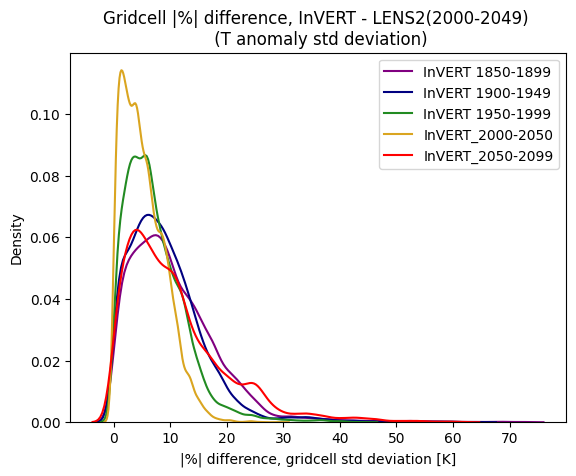

In [46]:
lens_ref_period = '2000-2049'
std_lens = std_lens4

invert1_std_pct_diff = (np.abs(std_invert1 - std_lens)/std_lens*100).values.flatten()
invert2_std_pct_diff = (np.abs(std_invert2 - std_lens)/std_lens*100).values.flatten()
invert3_std_pct_diff = (np.abs(std_invert3 - std_lens)/std_lens*100).values.flatten()
invert4_std_pct_diff = (np.abs(std_invert4 - std_lens)/std_lens*100).values.flatten()
invert5_std_pct_diff = (np.abs(std_invert5 - std_lens)/std_lens*100).values.flatten()

sns.kdeplot(invert1_std_pct_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_pct_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_pct_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_pct_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_pct_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('|%| difference, gridcell std deviation [K]')
plt.title('Gridcell |%| difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.pdf')

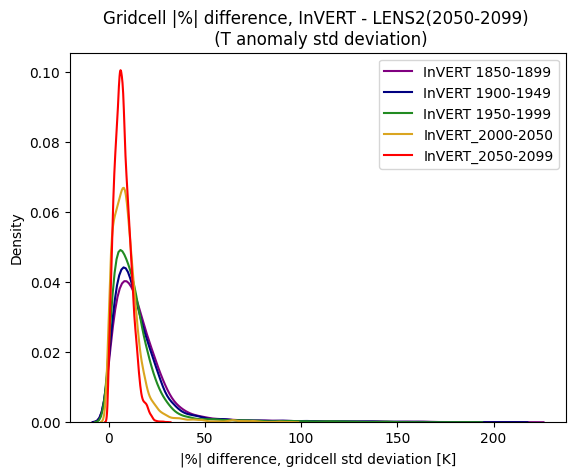

In [47]:
lens_ref_period = '2050-2099'
std_lens = std_lens5

invert1_std_pct_diff = (np.abs(std_invert1 - std_lens)/std_lens*100).values.flatten()
invert2_std_pct_diff = (np.abs(std_invert2 - std_lens)/std_lens*100).values.flatten()
invert3_std_pct_diff = (np.abs(std_invert3 - std_lens)/std_lens*100).values.flatten()
invert4_std_pct_diff = (np.abs(std_invert4 - std_lens)/std_lens*100).values.flatten()
invert5_std_pct_diff = (np.abs(std_invert5 - std_lens)/std_lens*100).values.flatten()

sns.kdeplot(invert1_std_pct_diff, label='InVERT 1850-1899', color='purple')
sns.kdeplot(invert2_std_pct_diff, label='InVERT 1900-1949', color='navy')
sns.kdeplot(invert3_std_pct_diff, label='InVERT 1950-1999', color='forestgreen')
sns.kdeplot(invert4_std_pct_diff, label='InVERT_2000-2050', color='goldenrod')
sns.kdeplot(invert5_std_pct_diff, label='InVERT_2050-2099', color='red')

plt.legend()
plt.xlabel('|%| difference, gridcell std deviation [K]')
plt.title('Gridcell |%| difference, InVERT - LENS2('+\
          lens_ref_period+') \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.png')
plt.savefig(savepath + 'Figure_S20_std_percent_diff_'+lens_ref_period+'.pdf')